In [2]:
from keras.models import Model,Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Input
from keras.optimizers import Adam
from collections import deque

import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import random
import math
 
class MarketEnv:
    
    def __init__(self, stock_data, charge, tax, interval):
        self.data        = stock_data
        self.charge      = charge
        self.interval    = interval
        self.tax         = tax
        self.reset()

    def step(self, action):
        
        reward = 0
        
        # Stay
        # if action == 0:
            # Do nothing
        
        # Buy
        if action == 1:
            self.inventory.append(self.data.iloc[self.t]['Closing Price']*(1.0 + self.charge))
            self.cost -= (self.data.iloc[self.t]['Closing Price']*(1.0 + self.charge))
            
        # Sell 
        elif action == 2 and len(self.inventory) != 0:
            profits = 0
            for price in self.inventory:
                profits += (self.data.iloc[self.t]['Closing Price']*(1.0 - self.charge - self.tax) - price)
                self.realizedGain += (self.data.iloc[self.t]['Closing Price']*(1.0 - self.charge - self.tax) - price)
                self.cost += self.data.iloc[self.t]['Closing Price']*(1.0 - self.charge - self.tax)
            reward       += profits
            self.profits += profits
            self.inventory = []
            
        
        # Next time step
        self.t += 1
        
        # The Unrealized Gain or Loss
        self.unrealizedGain = 0
        for price in self.inventory:
            self.unrealizedGain += (self.data.iloc[self.t]['Closing Price'] - price)
        
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t]['Closing Price'] - self.data.iloc[self.t-1]['Closing Price'])

        # clipping reward
        #if  reward > 0:
        #    reward = 1
        #elif reward < 0:
        #    reward = -1
            
        if self.t > len(self.data)-2:
            self.done = True
                            
        return [self.unrealizedGain] + self.history, reward, self.done
    
    def Get_final_inventory_value(self):
        self.inventory_value = 0
        for p in self.inventory:
            self.inventory_value += (self.data.iloc[self.t]['Closing Price'])
        return self.inventory_value

    def reset(self):
        self.t = 1
        self.done = False
        self.profits   = 0
        self.cost      = 0
        self.realizedGain   = 0
        self.unrealizedGain = 0 
        self.inventory = []
        self.inventory_value = 0
        self.history   = [0 for _ in range(self.interval)]
        return [self.unrealizedGain] + self.history 



In [3]:
# Double Deep Q-learning
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = 20
        self.memory  = deque(maxlen=1000)
        self.gamma   = 0.95             # discount rate
        self.epsilon = 1.0              # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.001
        self.model = self.build_model()
        self.target_model = self.build_model()
        
    def build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(256, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='softmax'))
        model.compile(loss='mse',optimizer='adam')
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(0,self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def replay(self):
        minibatch = self.sample(self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                predicted_action = np.argmax(self.model.predict(next_state)[0])                
                target = reward + self.gamma * self.target_model.predict(next_state)[0][predicted_action]  
                #target = (reward + self.gamma *
                #          np.amax(self.target_model.predict(next_state)[0]))           
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def update_model(self, total_step):
          if total_step % 10 == 0:      # %10
                weights = self.model.get_weights()
                target_weights = self.target_model.get_weights()
                for i in range(len(target_weights)):
                    target_weights[i] = weights[i]
                self.target_model.set_weights(target_weights)
                
    def save(self, file):
        self.model.save_weights(file)

    def load(self, file):
        self.model.load_weights(file)


In [4]:
stockNo = str('0050')
stock_price = pd.read_csv('./Data/'+stockNo+'_Price.csv') 
stock_price = stock_price.set_index('Date')

In [5]:
training_stock_price = stock_price[0:round(len(stock_price)*3/4)]
testing_stock_price  = stock_price[round(len(stock_price)*3/4)+1:]
print('Training Data: ',len(training_stock_price))
print('Testing Data: ',len(testing_stock_price))

Training Data:  2254
Testing Data:  750


In [8]:
interval    = 60
action_size = 3  # Stay Buy Sell
epoch_num   = 40
capacity    = 3000
total_day   = len(training_stock_price)
total_step  = 0
charge      = 0.001425 * 0.5 # 手續費
tax         = 0.003          # 交易稅
realizedGain = []
overallGain  = []
maxrealizedGain = 0
maxoverallGain  = 0
env = MarketEnv(training_stock_price,charge,tax,interval)
DQN_Agent   = DQNAgent(interval+1, action_size)

# start training
for epoch in range(epoch_num):
    cur_state  = env.reset()
    stay, buy, sell, condiction, money = 0,0,0,0,0
    for step_i in range(total_day):
        total_step += 1
        cur_state  = np.reshape(cur_state, [1, DQN_Agent.state_size])

        if total_step > capacity:
            action = DQN_Agent.act(cur_state)
        else:
            action = np.random.randint(0, 3)   

        if   action == 0:
            stay  += 1
        elif action == 1:
            buy   += 1
        elif action == 2:
            if len(env.inventory) == 0:
                stay  += 1
                condiction +=1
                action = 0
            else:
                sell  += 1

        observation, reward, done  = env.step(action)
        observation = np.reshape(observation, [1, DQN_Agent.state_size])
        DQN_Agent.remember(cur_state, action, reward , observation, done)

        if total_step > capacity:
            DQN_Agent.replay()
            DQN_Agent.update_model(total_step)

        cur_state = observation

        money += reward
        
        if env.done:
            break
        

    if epoch % 1 == 0:
        realizedGain.append(env.realizedGain)
        overallGain.append(env.realizedGain+env.unrealizedGain)
        
        if env.realizedGain > maxrealizedGain:
            DQN_Agent.save('./Model/'+stockNo+' MarketAgent_DDQN_Model.h5')
            maxrealizedGain = env.realizedGain
            
        print("==================================================")
        print("       "+stockNo+" Stock Strategy Learning Result")   
        print("==================================================")
        #print("                         Profit:%8.2f " % (env.profits))
        print("                     Total Cash: %8.2f " % (env.cost))
        print("          Final Inventory value: %8.2f " % (env.Get_final_inventory_value()))
        print("          Realized Gain or Loss: %8.2f " % (env.realizedGain))
        print("        Unrealized Gain or Loss: %8.2f " % (env.unrealizedGain))
        print("           Overall Gain or Loss: %8.2f " % (env.cost+env.Get_final_inventory_value()))
        print("==================================================")
        print("Stay:%4d   Buy:%4d   Sell:%4d  Condiction:%4d" % (stay,buy,sell,condiction))
        print("Episode {0:3d}/{1:3d}, Reward:{2:8.2f}, Epsilon: {3:6.4f}".format(epoch, epoch_num, money, DQN_Agent.epsilon))
        print()
        print()


       0050 Stock Strategy Learning Result
                     Total Cash:  -467.30 
          Final Inventory value:   219.60 
          Realized Gain or Loss:  -249.39 
        Unrealized Gain or Loss:     1.69 
           Overall Gain or Loss:  -247.70 
Stay:1153   Buy: 736   Sell: 363  Condiction: 387
Episode   0/ 40, Reward: -249.39, Epsilon: 1.0000


       0050 Stock Strategy Learning Result
                     Total Cash:  -245.19 
          Final Inventory value:   219.60 
          Realized Gain or Loss:   -26.88 
        Unrealized Gain or Loss:     1.29 
           Overall Gain or Loss:   -25.59 
Stay:1203   Buy: 829   Sell: 220  Condiction: 134
Episode   1/ 40, Reward:  -26.88, Epsilon: 0.0010


       0050 Stock Strategy Learning Result
                     Total Cash:   546.05 
          Final Inventory value:     0.00 
          Realized Gain or Loss:   546.05 
        Unrealized Gain or Loss:     0.00 
           Overall Gain or Loss:   546.05 
Stay: 516   Buy:1551  

       0050 Stock Strategy Learning Result
                     Total Cash: -1135.29 
          Final Inventory value:   658.80 
          Realized Gain or Loss:  -479.73 
        Unrealized Gain or Loss:     3.23 
           Overall Gain or Loss:  -476.49 
Stay:  59   Buy:2010   Sell: 183  Condiction:   0
Episode  16/ 40, Reward: -479.73, Epsilon: 0.0010


       0050 Stock Strategy Learning Result
                     Total Cash:   358.58 
          Final Inventory value:   658.80 
          Realized Gain or Loss:  1014.14 
        Unrealized Gain or Loss:     3.23 
           Overall Gain or Loss:  1017.38 
Stay:  52   Buy:2012   Sell: 188  Condiction:   0
Episode  17/ 40, Reward: 1014.14, Epsilon: 0.0010


       0050 Stock Strategy Learning Result
                     Total Cash:   358.10 
          Final Inventory value:   658.80 
          Realized Gain or Loss:  1013.66 
        Unrealized Gain or Loss:     3.23 
           Overall Gain or Loss:  1016.90 
Stay:  52   Buy:2014  

       0050 Stock Strategy Learning Result
                     Total Cash:   360.95 
          Final Inventory value:   658.80 
          Realized Gain or Loss:  1016.52 
        Unrealized Gain or Loss:     3.23 
           Overall Gain or Loss:  1019.75 
Stay:  49   Buy:2013   Sell: 190  Condiction:   0
Episode  32/ 40, Reward: 1016.52, Epsilon: 0.0010


       0050 Stock Strategy Learning Result
                     Total Cash:   240.22 
          Final Inventory value:   658.80 
          Realized Gain or Loss:   895.79 
        Unrealized Gain or Loss:     3.23 
           Overall Gain or Loss:   899.02 
Stay:  45   Buy:2011   Sell: 196  Condiction:   0
Episode  33/ 40, Reward:  895.79, Epsilon: 0.0010


       0050 Stock Strategy Learning Result
                     Total Cash:   329.44 
          Final Inventory value:   658.80 
          Realized Gain or Loss:   985.00 
        Unrealized Gain or Loss:     3.23 
           Overall Gain or Loss:   988.24 
Stay:  49   Buy:2007  

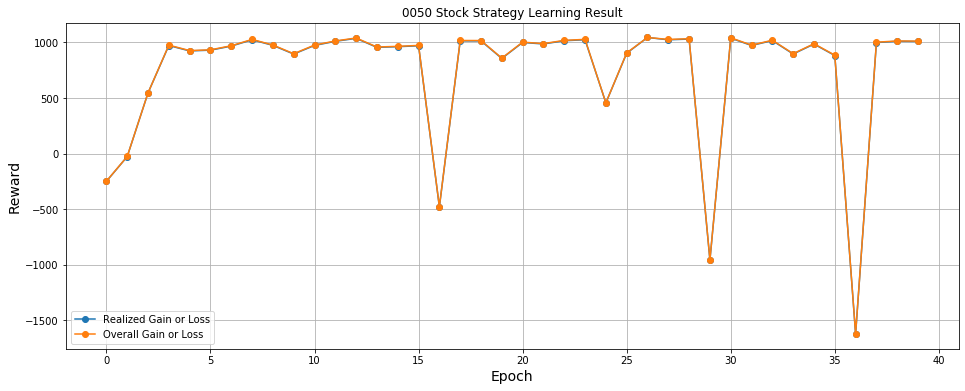

In [9]:
ax = np.linspace(0,epoch_num-1,epoch_num)
plt.figure(figsize=(16,6))
plt.plot(ax,realizedGain, label='Realized Gain or Loss', marker='o')
plt.plot(ax,overallGain, label='Overall Gain or Loss', marker='o')
plt.title(stockNo + ' Stock Strategy Learning Result')
plt.legend(loc='best')
plt.xlabel('Epoch', fontsize=14) 
plt.ylabel('Reward', fontsize=14) 
plt.grid(True)
plt.show()

In [16]:
interval    = 60
action_size = 3  # Stay Buy Sell
charge      = 0.001425 * 0.5 # 手續費
tax         = 0.003          # 交易稅
#env = MarketEnv(testing_stock_price,charge,tax,interval)
env = MarketEnv(stock_price,charge,tax,interval)

#DQN_Agent.load('./Model/'+stockNo+' MarketAgent_DDQN_Model.h5') 
#total_day  = len(testing_stock_price)
total_day  = len(stock_price)

cur_state  = env.reset()
stay, buy, sell, condiction, money = 0,0,0,0,0
actions    = []
inventory  = []
assets     = []
for step_i in range(total_day):
    cur_state  = np.reshape(cur_state, [1, DQN_Agent.state_size])

    action = DQN_Agent.act(cur_state)
    
    if   action == 0:
        stay  += 1
        actions.append(0)
    elif action == 1:
        buy   += 1
        actions.append(1)
    elif action == 2:
        if len(env.inventory) == 0:
            stay  += 1
            condiction += 1
            #actions.append(-2)
            actions.append(0)
            action = 0
        else:
            sell  += 1
            actions.append(-1)
    
    inventory.append(len(env.inventory))
    assets.append(env.cost+env.Get_final_inventory_value())

    observation, reward, done  = env.step(action)
    observation = np.reshape(observation, [1, DQN_Agent.state_size])
    #DQN_Agent.replay()
    cur_state = observation

    if env.done:
        break

#DQN_Agent.save('./Model/'+stockNo+' MarketAgent_DDQN_Model.h5')
        
print("==================================================")
print("       "+stockNo+" Stock Strategy Learning Result")   
print("==================================================")
print("                     Total Cash: %8.2f " % (env.cost))
print("          Final Inventory value: %8.2f " % (env.Get_final_inventory_value()))
print("          Realized Gain or Loss: %8.2f " % (env.realizedGain))
print("        Unrealized Gain or Loss: %8.2f " % (env.unrealizedGain))
print("           Overall Gain or Loss: %8.2f " % (env.cost+env.Get_final_inventory_value()))
print("==================================================")
print("Stay:%4d   Buy:%4d   Sell:%4d   Condiction:%4d" % (stay,buy,sell,condiction))


       0050 Stock Strategy Learning Result
                     Total Cash: -2115.73 
          Final Inventory value:  2769.45 
          Realized Gain or Loss:  1230.95 
        Unrealized Gain or Loss:  -577.23 
           Overall Gain or Loss:   653.72 
Stay:  88   Buy:2671   Sell: 244   Condiction:   0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


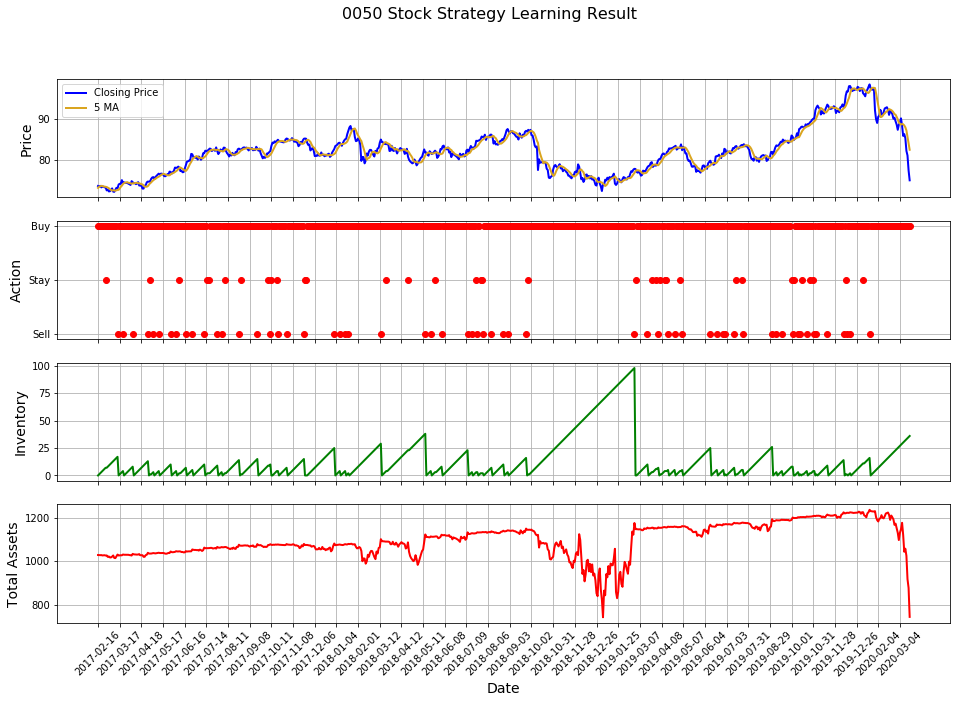

In [20]:
#day  = 500
day  = len(testing_stock_price)
action_record = pd.DataFrame(actions[-day:],columns=['Action'])
action_record = action_record.set_index(stock_price.index[-day:])
inventory_record = pd.DataFrame(inventory[-day:],columns=['Volume'])
inventory_record = inventory_record.set_index(stock_price.index[-day:])
assets_record = pd.DataFrame(assets[-day:],columns=['Dollar'])
assets_record = assets_record.set_index(stock_price.index[-day:])

denorm_5ma = stock_price['Closing Price'].rolling(5).mean().shift()
denorm_5ma = denorm_5ma.iloc[-day:]

fig, ax = plt.subplots(4, 1, sharex=True ,figsize=(16,10))
ax[0].plot(stock_price['Closing Price'][-day:],color='blue', label='Closing Price', linewidth=2)
ax[0].plot(denorm_5ma[-day:],color='goldenrod', label='5 MA', linewidth=2)
ax[0].legend(loc='best')
ax[0].set_ylabel('Price', fontsize=14) 
ax[0].grid(True)

ax[1].plot(action_record['Action'],color='red',linestyle='None', marker='o')

ax[1].set_ylabel('Action', fontsize=14) 
#ax[1].set_yticks([-2,-1,0,1]) 
#ax[1].set_yticklabels(['Short','Sell','Stay','Buy'])
ax[1].set_yticks([-1,0,1]) 
ax[1].set_yticklabels(['Sell','Stay','Buy'])
ax[1].grid(True)

ax[2].plot(inventory_record['Volume'],color='green',label='Volume', marker='None', linewidth=2)
ax[2].set_ylabel('Inventory', fontsize=14) 
ax[2].grid(True)

ax[3].plot(assets_record['Dollar'] ,color='red', marker='None', linewidth=2)
ax[3].set_ylabel('Total Assets', fontsize=14) 
ax[3].grid(True)

plt.xlabel('Date', fontsize=14) 
plt.xticks(rotation=45)
plt.xticks(np.arange(0, day, step=20))

fig.suptitle(stockNo + ' Stock Strategy Learning Result', fontsize=16)
fig.show()